##### Setup (imports, constants, etc.)

In [29]:
import multiprocessing

start_method = 'forkserver'
try:
    multiprocessing.set_start_method(start_method)
except RuntimeError as e:
    if str(e) != 'context has already been set':
        raise e
    elif multiprocessing.get_start_method() != start_method:
        raise RuntimeWarning(
            'Multiprocessing start_method {} was not set.'
            .format(start_method)
        )

from copy import deepcopy
import pdb
import warnings
from imp import reload
import time
from pprint import pprint
import random
from copy import deepcopy
import pickle
import time
import multiprocessing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (StratifiedShuffleSplit, train_test_split,
                                     validation_curve)
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import (SelectKBest, chi2, mutual_info_classif,
                                       f_classif)
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, make_scorer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import (LabelBinarizer, LabelEncoder,
                                   MinMaxScaler, StandardScaler,
                                   OneHotEncoder, Imputer)
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from IPython.display import display, Image
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
from xgboost import XGBClassifier
from pyglmnet import GLM
from sklearn.utils.validation import check_is_fitted
from tpot import TPOTClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.externals import joblib

import pdir

from outlier_detection import *
from preprocessing import (LogTransformer, SqrtTransformer, BedBathImputer,
                           LatLongImputer, LenExtractor, GroupSumExtractor,
                           WordCntExtractor, DayBinarizer, ItemSelector,
                           feature_prep, impute_w_constant)
from eda_plots import *
from validation_plots import *
from main import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

pd.set_option('display.float_format', lambda x: '%.4f' % x)

SEED = 42
np.random.seed(SEED)

DAT_DIR = '../Data/'
SUBM_DIR = '../Submissions/'
TEST_DIR = '../Tests/'
REPORT_IMG_DIR = '../Report-Images/'
TPOT_DIR = './TPOT/'
MODEL_DIR = './Models/'

TRAIN_FP = ''.join([DAT_DIR, 'train.json'])
TEST_FP = ''.join([DAT_DIR, 'test.json'])
SAMPLE_FP = ''.join([DAT_DIR, 'sample_submission.csv'])
DF_TRAIN_PKL = ''.join([DAT_DIR, 'df_train.pkl'])
DF_TEST_PKL = ''.join([DAT_DIR, 'df_test.pkl'])
GRID_S1_FP = ''.join([MODEL_DIR, 'grid_s1.pkl'])
GRID_S2_FP = ''.join([MODEL_DIR, 'grid_s2.pkl'])
GRID_S3_FP = ''.join([MODEL_DIR, 'grid_s3.pkl'])
GRID_S4_FP = ''.join([MODEL_DIR, 'grid_s4.pkl'])

scorer_acc = make_scorer(accuracy_score)

# using built-in 'neg_log_loss' scoring param used for simplicity
# source code show exact same make_scorer call, kept for reference
scorer = make_scorer(log_loss, greater_is_better=False,
                     needs_proba=True)

scoring = 'neg_log_loss'

df = read_rental_interest(DF_TRAIN_PKL)
df_te = read_rental_interest(DF_TEST_PKL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


RuntimeWarning: Multiprocessing start_method was not set.

# Notes

__About the target variable__:
- From Kaggle: "The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site."
- This means listings taken down quickly due to a quick close will be classified with the same interest level as one that takes longer to close and has the same number of inquiries.
- If we take a more holistic approach to interest level, another distortion could arise with listings that have lots of inquiries due to listings that are higher quality relative to the actual property.
- Ultimately, the distorting factor of duration is unknown because, assuming the listing were shown as they are now, the search ranking is determined not only by "freshness" but also by the quality of the posting and the property itself (possibly derived from interest level). 

__Dealing with class imbalance__:
- High: 0.078, medium: 0.228, low: 0.695
- https://stats.stackexchange.com/questions/122409/why-downsample
- For probabilistic models, we need that informatation of the imbalance!
- If balance, logloss worse than benchmark

__Logistic Regression__
- Cost function favors majority class, but so does the class distribution!
- ~~`Sklearn` implementation has `weight` parameter with `balanced` option.~~

__Dealing with outliers__:
- Examine with HDBSCAN
- Look at classes of outliers

__Logistic Regression__:
- http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
- `Liblinear` only compatible with `ovr`, use others for `multinomial`
- For build-in CV for regularization strength, use: [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

__Gradient boosted trees__:
- 

Stochastic Gradient Descent with modified huber loss:
- using sklearn's [`SGDClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- `modified_huber` is another smooth loss that brings tolerance to outliers as well as probability estimates

__Train test split__

- 

# Learning

## Stage 1: Benchmark

In [ ]:
df = read_rental_interest(DF_TRAIN_PKL)
y = LabelBinarizer().fit_transform(df.interest_level)

avg_probs = (np.sum(y, axis=0)/len(y)).tolist()
baseline_pred = np.array(avg_probs*len(y)).reshape(-1, 3)
baseline_score = log_loss(y, baseline_pred)
baseline_score

## Stage 2: Spot-Check

Basic features:
- Price (logged), Bedrooms, Bathrooms, Latitude, Longitude
- Binarized day created (Monday, Tuesday, etc.)
- Number of photos, features and description word count
- Indicator variables for zero values of counts above (ignored by XGBoost)

### Uniform Setup for Spot-Checks

In [2]:
features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level

X_prepped = feature_prep(X).loc[:, features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y, test_size=.25,
)d

# labels are reduced by one to match num_label format in xgb
dtrain = xgb.DMatrix(X_train, y_train-1, feature_names=features)
dtest  = xgb.DMatrix(X_test, y_test-1, feature_names=features)

### Logistic Regression  Spot Check

8.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.7003 ± 0.0039 (mean ± std. dev.)
Train score:        -0.6984 ± 0.0010 (mean ± std. dev.)

*** For parameters: ***
lr_clf__C=0.1

4.67 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


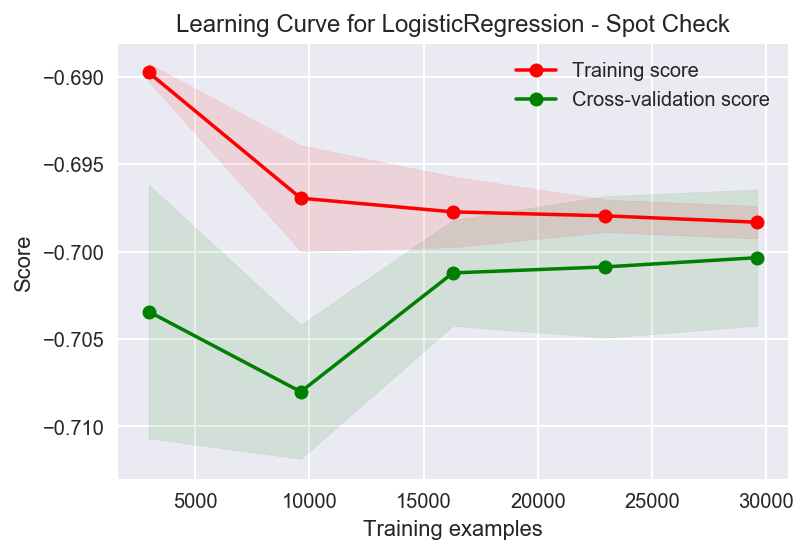

In [3]:
lr_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                            n_jobs=1, random_state=SEED)

pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('lr_clf', lr_clf)
])

params = dict(
    lr_clf__C=np.logspace(-4, 4, 9),
)
grid = GridSearchCV(pipe, params, n_jobs=-1, scoring=scoring, cv=5)

%timeit -r1 -n1 grid.fit(X_train, y_train)

print()
print(best_grid_score(grid))
print()

clf = grid.best_estimator_

# kwargs so %timeit works with multiline arguments
kwargs = dict(estimator=clf, X=X_train, y=y_train,
              clf_name='LogisticRegression - Spot Check',
              cv=5, scoring=scoring, n_jobs=-1)

%timeit -r1 -n1 plot_learning_curve(**kwargs)

fp = ''.join([REPORT_IMG_DIR, 'spchk-lr-learning-curve.png'])
# plt.savefig(fp, dpi=300, bbox_inches='tight')

Output:
```
9.61 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.7003 ± 0.0039 (mean ± std. dev.)
Train score:        -0.6984 ± 0.0010 (mean ± std. dev.)

*** For parameters: ***
lr_clf__C=0.1

5.32 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
[plot image]
```

### XGBoost Spot Check

In [4]:
RUN_XGB = True

if RUN_XGB:

    params = dict(
        objective='multi:softprob',
        
        learning_rate=0.05,  # low bias model, using 5/n-rounds
        max_depth=5,
        
        num_class=3, silent=True,
        n_jobs=-1, seed=SEED, 
    )

    start = time.time()
    eval_hist = xgb.cv(
        params, dtrain,
        
        num_boost_round=500,
        early_stopping_rounds=25,
        verbose_eval=25,
        
        metrics='mlogloss',
        seed=SEED, stratified=True, nfold=4,
    )

    end = time.time()
    print()
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    print()
    print(best_xgb_cv_score(eval_hist))
    

[0]	train-mlogloss:1.06952+8.70833e-05	test-mlogloss:1.06989+0.000239795
[25]	train-mlogloss:0.745183+0.000710098	test-mlogloss:0.752475+0.000791751
[50]	train-mlogloss:0.669701+0.000824884	test-mlogloss:0.682773+0.000645682
[75]	train-mlogloss:0.641654+0.000848893	test-mlogloss:0.660293+0.000994237
[100]	train-mlogloss:0.622907+0.000991386	test-mlogloss:0.647477+0.00121865
[125]	train-mlogloss:0.609655+0.00128791	test-mlogloss:0.639763+0.00111081
[150]	train-mlogloss:0.599092+0.00114662	test-mlogloss:0.634373+0.00119398
[175]	train-mlogloss:0.58997+0.00109532	test-mlogloss:0.630557+0.00125458
[200]	train-mlogloss:0.582148+0.00125379	test-mlogloss:0.627498+0.00130493
[225]	train-mlogloss:0.575083+0.00159309	test-mlogloss:0.625279+0.00139835
[250]	train-mlogloss:0.568678+0.00176748	test-mlogloss:0.623533+0.0013434
[275]	train-mlogloss:0.562781+0.00189738	test-mlogloss:0.622236+0.00145169
[300]	train-mlogloss:0.556955+0.001829	test-mlogloss:0.621124+0.0015348
[325]	train-mlogloss:0.55180

Output:
```
[0]	train-mlogloss:1.06849+8.31775e-05	test-mlogloss:1.06912+0.000210486
[25]	train-mlogloss:0.731956+0.00109017	test-mlogloss:0.745194+0.000914282
[50]	train-mlogloss:0.651172+0.000965228	test-mlogloss:0.673908+0.000826646
[75]	train-mlogloss:0.619362+0.00108473	test-mlogloss:0.651216+0.00112256
[100]	train-mlogloss:0.597604+0.000980004	test-mlogloss:0.639301+0.00152382
[125]	train-mlogloss:0.581041+0.000960965	test-mlogloss:0.63192+0.00150168
[150]	train-mlogloss:0.567778+0.001178	test-mlogloss:0.627592+0.00163918
[175]	train-mlogloss:0.556712+0.00120125	test-mlogloss:0.624627+0.00150269
[200]	train-mlogloss:0.546591+0.00168898	test-mlogloss:0.622696+0.00161003
[225]	train-mlogloss:0.537582+0.00201685	test-mlogloss:0.62132+0.00174716
[250]	train-mlogloss:0.529489+0.00265884	test-mlogloss:0.620444+0.00182089
[275]	train-mlogloss:0.5217+0.00270978	test-mlogloss:0.61989+0.00186883
[300]	train-mlogloss:0.514463+0.00330941	test-mlogloss:0.619333+0.00181933
[325]	train-mlogloss:0.507482+0.00332606	test-mlogloss:0.618996+0.00197248
[350]	train-mlogloss:0.500887+0.00360546	test-mlogloss:0.618774+0.001975
[375]	train-mlogloss:0.494373+0.00367272	test-mlogloss:0.618695+0.0020946

Runtime: 1min 52s

Best CV score (round 371):  0.6187 ± 0.0021 (mean ± std. dev.)
Train score (round 371):    0.4955 ± 0.0036 (mean ± std. dev.)
```

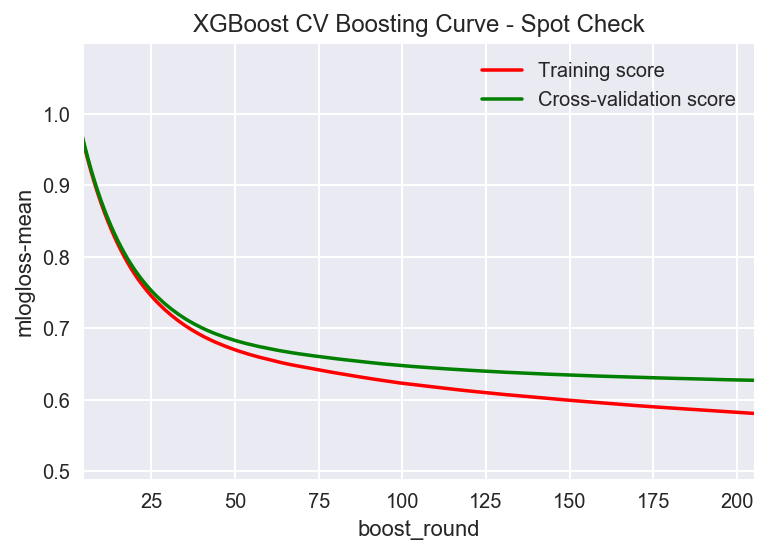

In [8]:
fp = ''.join([REPORT_IMG_DIR, 'spchk-xgb-boosting-curve.png'])
if RUN_XGB:
    ax = plot_xgb_boosting_curve(eval_hist, xlim=(5, 205))
    ax.set_title(ax.get_title() + ' - Spot Check')
    plt.savefig(fp, dpi=300, bbox_inches='tight')
else:
    display(Image(fp, width=500))

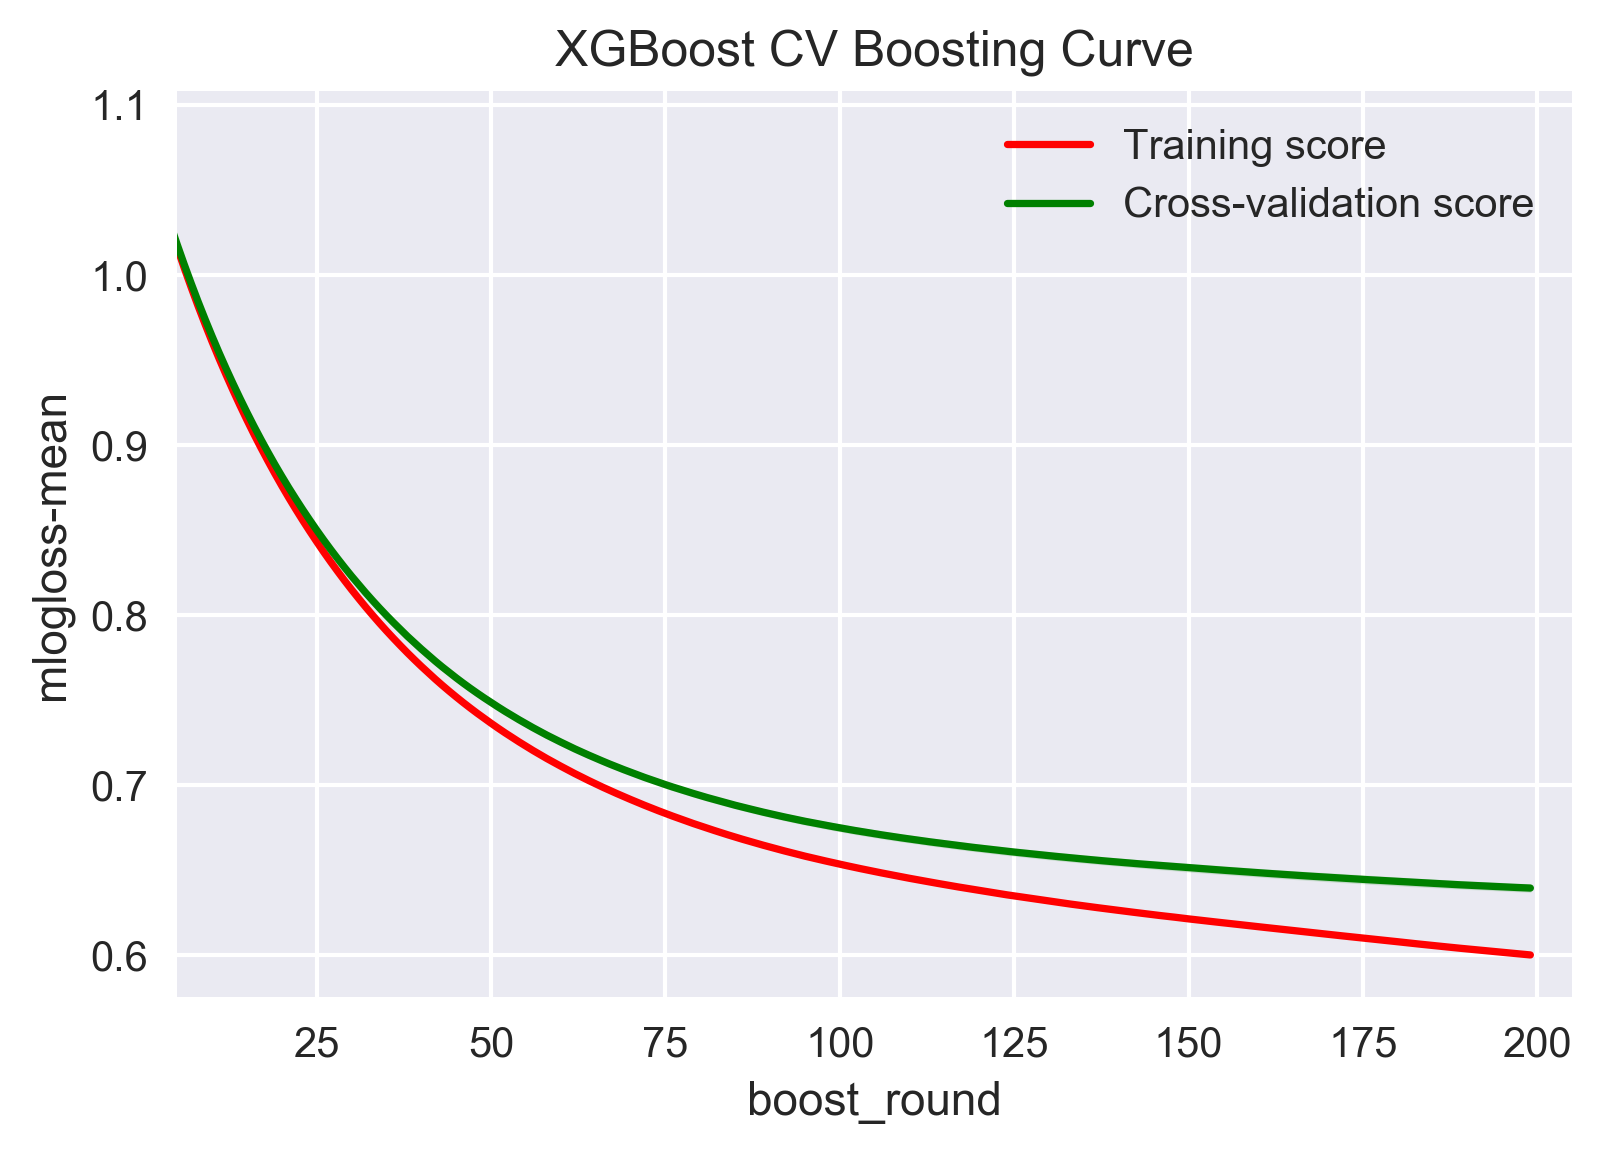

In [3]:
fp = ''.join([REPORT_IMG_DIR, 'stg2-boosting-curve.png'])
if RUN_XGB:
    plot_xgb_boosting_curve(eval_hist, xlim=(5, 205))
    # plt.savefig(fp, dpi=300, bbox_inches='tight')
else:
    display(Image(fp, width=500))

Runtime: 0min 37s


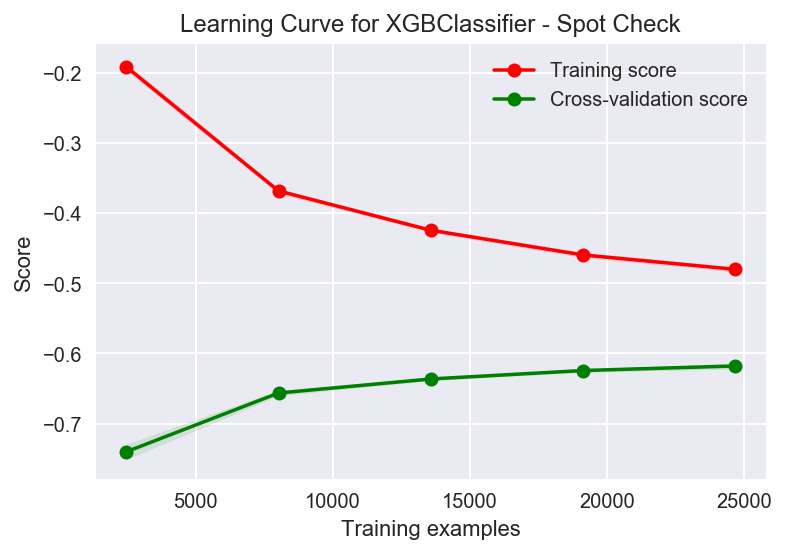

In [10]:
fp = ''.join([REPORT_IMG_DIR, 'spchk-xgb-learning-curve.png'])
if RUN_XGB:
    xgb_clf = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        
        objective='multi:softprob',
        nthread=1, seed=SEED,
    )
    start = time.time()
    plot_learning_curve(
        estimator=xgb_clf, X=X_train, y=y_train,
        clf_name='XGBClassifier - Spot Check',
        cv=3, scoring=scoring, n_jobs=-1
    )
    end = time.time()
    
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    
    plt.savefig(fp, dpi=300, bbox_inches='tight')
else:
    display(Image(fp, width=500))

Output:
```
Runtime: 0min 37s
```

### TPOT

In [19]:
if 1 == 0:

    tpot_light = TPOTClassifier(
        generations=5, population_size=20, verbosity=2,
        scoring='neg_log_loss', random_state=SEED, n_jobs=1,
        config_dict=''.join([TPOT_DIR, 'classifier_light.py'])
    )
    tpot_light.fit(X_train, y_train)
    tpot_light.export(''.join([TPOT_DIR, 'tpot_bench_light.py']))
    pickle.dump(tpot_light, ''.join([TPOT_DIR, 'tpot_bench_light.pkl']))

Output:
```
Generation 5 - Current best internal CV score: 0.6708706420692458

Best pipeline: LogisticRegression(DecisionTreeClassifier(StandardScaler(input_matrix), DecisionTreeClassifier__criterion=DEFAULT, DecisionTreeClassifier__max_depth=10, DecisionTreeClassifier__min_samples_leaf=19, DecisionTreeClassifier__min_samples_split=17), LogisticRegression__C=25.0, LogisticRegression__dual=DEFAULT, LogisticRegression__penalty=DEFAULT)
```

In [18]:
if 1 == 0:
    tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2,
                          scoring=scoring, random_state=SEED, n_jobs=1,
    )
    %timeit -r1 -n1 tpot.fit(X_train, y_train)
    tpot.export(''.join([TPOT_DIR, 'tpot_bench.py']))
    pickle.dump(tpot, ''.join([TPOT_DIR, 'tpot_bench.pkl']))

Output:
```
Generation 5 - Current best internal CV score: 0.6185133810756033

Best pipeline: XGBClassifier(input_matrix, XGBClassifier__learning_rate=DEFAULT, XGBClassifier__max_depth=6, XGBClassifier__min_child_weight=4, XGBClassifier__n_estimators=100, XGBClassifier__n_jobs=1, XGBClassifier__subsample=0.45)
51min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
```

## Stage 3: Model Refinement
- Refine XGBoost, best performing model in spot-check

### Parameter Notes

- For imbalanced classes and speed
    - `scale_pos_weigh`, [default=1] (faster, no effect on score)
        - See speed improvement section for details
    - `max_delta_step`, [default=0]
        - From overfitting guide: If you care about predicting the right probability
In such a case, you cannot re-balance the dataset
In such a case, set parameter `max_delta_step` to a finite number (say 1) will help convergence
        - From docs: Maximum delta step we allow each tree's weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative. Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update

### Uniform Setup for Refinements

Same as spot-check data, just with missing data val -999 imputed

In [11]:
features = [
    'price_lg', 'bedrooms', 'bathrooms', 'latitude', 'longitude',
    'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq',  # count aggregates
    'day_mon', 'day_tue', 'day_wed', 'day_thu',    # day dummies
    'day_fri', 'day_sat', 'day_sun',
]

df = read_rental_interest(DF_TRAIN_PKL)

X, y = df.drop('interest_level', axis=1), df.interest_level


X_prepped = feature_prep(X, imp_constant=-999).loc[:, features]

X_train, X_test, y_train, y_test = train_test_split(
    X_prepped, y, random_state=SEED, stratify=y, test_size=.25,`
)

# labels are reduced by one to match num_label format in xgb
dtrain = xgb.DMatrix(X_train, y_train-1, feature_names=features,
                     missing=-999)
dtest  = xgb.DMatrix(X_test, y_test-1, feature_names=features,
                     missing=-999)

In [78]:
# extractor = FeatureUnion([
#     ('pre_processed', ItemSelector(
#         ['price_lg', 'n_photos_sq', 'n_feats_sq', 'descr_wcnt_sq'])),
#     ('coordinates', make_pipeline(
#         ItemSelector(['latitude', 'longitude']),
#         LatLongImputer(how='mean', broad=False),
#     )),
#     ('rooms', make_pipeline(
#         ItemSelector(['bathrooms', 'bedrooms']),
#         BedBathImputer(how='medians'))),   
#     ('day_dummies', ItemSelector([
#         'day_mon', 'day_tue', 'day_wed', 'day_thu',
#         'day_fri', 'day_sat', 'day_sun' 
#     ])),
# ])

### Stage 3: Assess XGBoost's missing value handling

In [18]:
RUN_XGB = False

if RUN_XGB:

    # Same model from spot check grid search
    xgb_clf = XGBClassifier(
        max_depth=5,
        n_estimators=200,
        
        objective='multi:softprob',
        missing=-999, nthread=1, seed=SEED,
    )
    
    start = time.time()
    scores = cross_val_score(
        estimator=xgb_clf, X=X_train, y=y_train,
        fit_params=dict(eval_metric='mlogloss'),
        cv=5, scoring=scoring, n_jobs=-1,
    )
    y_pred = xgb_clf.fit(X_train, y_train).predict_proba(X_train)
    end = time.time()
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    print()
    print('Mean CV score: {:>10.4f}'.format(np.mean(scores)))
    print('Train score:   {:>10.4f}'.format(-log_loss(y_train, y_pred)))


Output:
```
Runtime: 0min 41s

Mean CV score:    -0.6167
Train score:      -0.5475
```

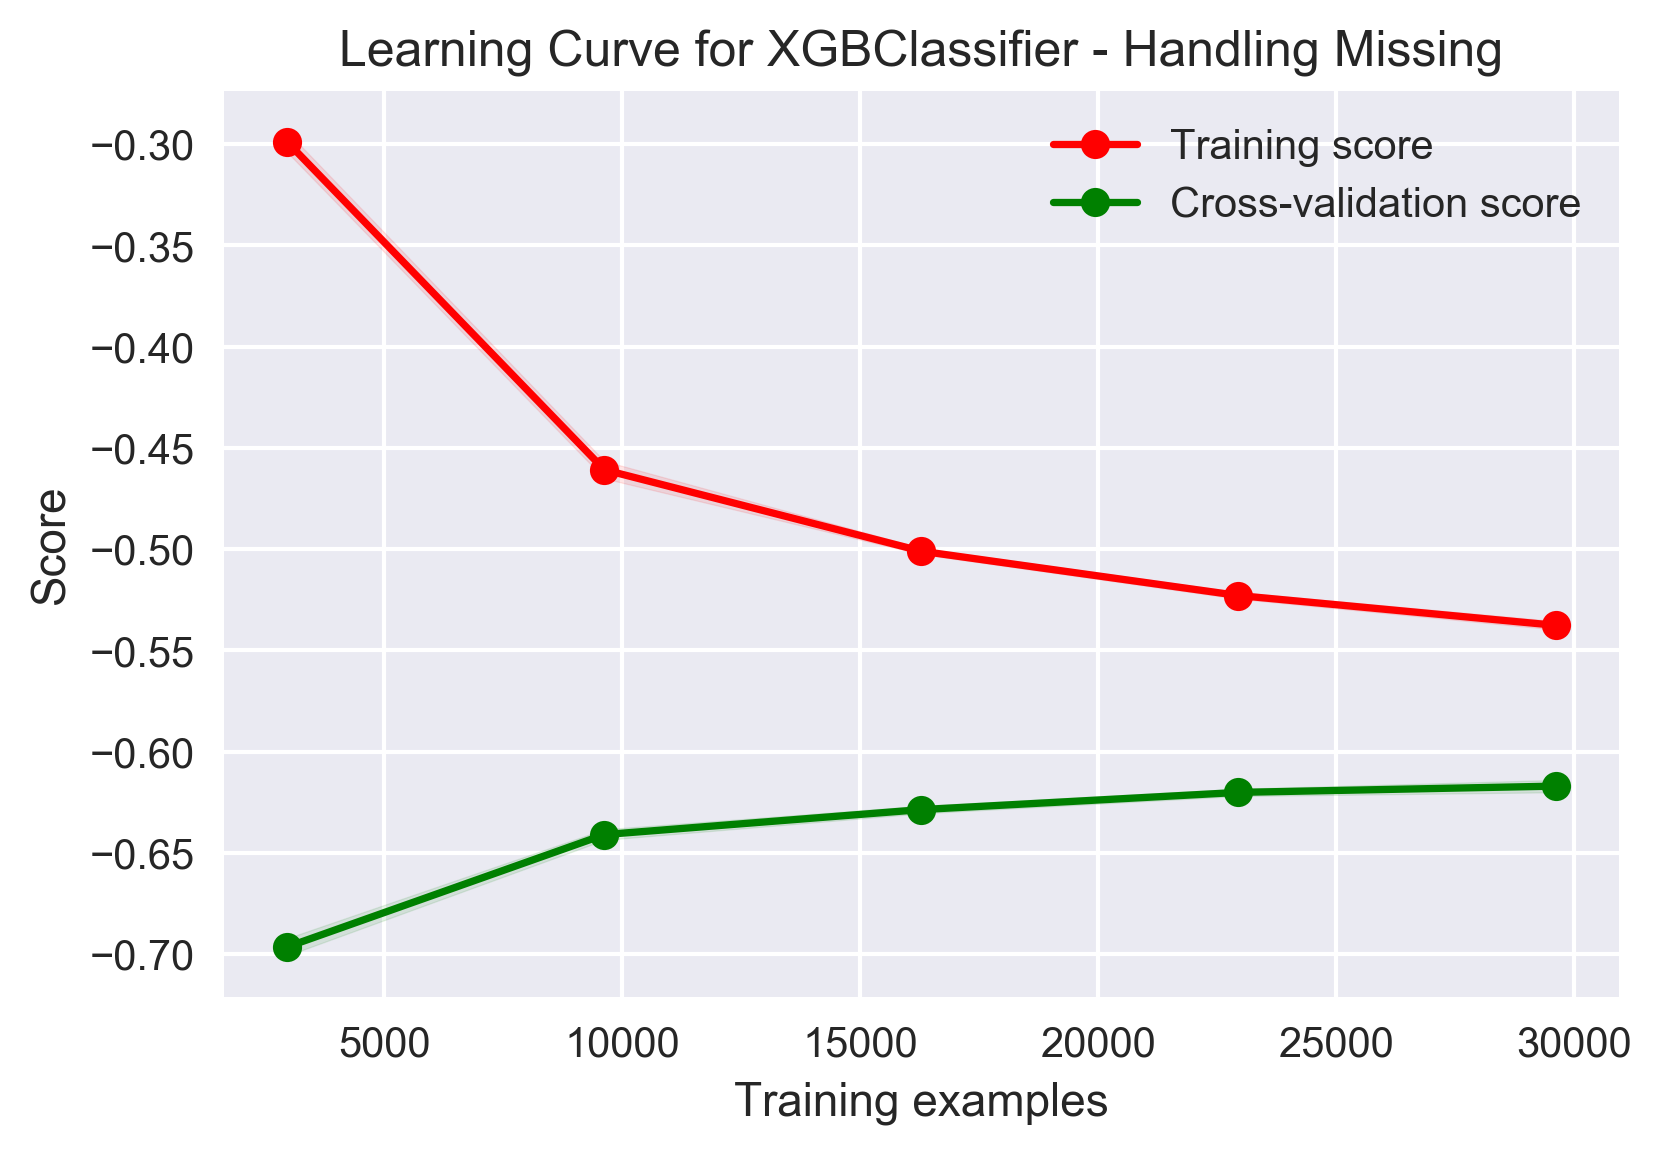

In [21]:
fp = ''.join([REPORT_IMG_DIR, 'missval-xgb-learning-curve.png'])

if RUN_XGB:
    start = time.time()
    ax = plot_learning_curve(estimator=xgb_clf, X=X_train, y=y_train,
                             clf_name='XGBClassifier - Handling Missing',
                             cv=5, scoring=scoring, n_jobs=-1)
    end = time.time()
    print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
    
#     plt.savefig(fp, dpi=300, bbox_inches='tight')
else:
    display(Image(fp, width=500))


Output:
```
Runtime: 1min 34s
```

### Stage 4: Hyperparameter Tuning

Method adapted from: Complete Guide to Parameter Tuning in XGBoost [blog post](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/) on Analytics Vidhya

- Native XGBoost multithreading does not work within ipython notebook, without messy `%writefile`/`%run` hack. 
    - This is fine given that `xgb.cv` is barely used instead of `GridSearchCV`
    - Info from xgboost [github script](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_parallel.py):
```python
# NOTE: on posix systems, this *has* to be here and in the
# `__name__ == "__main__"` clause to run XGBoost in parallel processes
# using fork, if XGBoost was built with OpenMP support. Otherwise, if you
# build XGBoost without OpenMP support, you can use fork, which is the
# default backend for joblib, and omit this.
```

Controls complexity:
- max_depth
- gamma
- min_child_weight

Robust to noise:
- sample_bytree (tune before subsample)
- subsample 

#### Step 1: Tune `max_depth` and `gamma`

"We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges."

`min_child_weight`, [default=1]
- One of first ways to control model complexity (with max_depth and gamma)
- Lower values can lower bias when classes are imbalanced
- Docs: "Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.
- In linear regression mode, this simply corresponds to minimum number of instances needed to be in each node. The larger, the more conservative the algorithm will be."

max_depth and gamma:

In [ ]:
# RUN_XGB = False

# if RUN_XGB:
#     num_boost_round = 500
#     early_stopping_rounds = 25
#     verbose_eval = 25

#     params = dict(
#         learning_rate=0.025,  # low bias model, using 5/n-rounds
#         max_depth=6,          
#         gamma=.1
        
#         objective='multi:softprob',
#         n_jobs=-1, seed=SEED,
#         num_class=3, eval_metric='mlogloss',        
#     )

#     start = time.time()
#     eval_hist = xgb.cv(
#         params, dtrain,
#         nfold=5, stratified=True, seed=SEED,
#         num_boost_round=num_boost_round,
#         early_stopping_rounds=early_stopping_rounds,
#         verbose_eval=verbose_eval,
#     )

#     end = time.time()
#     print()
#     print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
#     print()
#     print(best_xgb_cv_score(eval_hist))
      # xgb.cv

In [39]:
RUN_XGB = False

if RUN_XGB:
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        
        n_estimators=500,
        learning_rate=0.05,
        
        missing=-999, nthread=1, seed=SEED,
    )
    params = dict(
        max_depth=[3, 4, 5, 6],
        gamma=[.01, .1, .3, .8],
    )
    
    # TODO: Look into custom feval to return best score when 
    # stopped early (instead of most recent one, default behavior).
    
    # Speeds things up primarily (and prevents some overfitting).
    # Also helps to have some way of dealing with different sizes
    # of datasets (given the folds)
    fit_params=dict(
        early_stopping_rounds=25, 
        eval_metric='mlogloss', 
        eval_set=[(X_test, y_test)],
        verbose=False,
    )
    grid_s1 = GridSearchCV(xgb_clf, params, fit_params=fit_params,
                           scoring=scoring, cv=4, n_jobs=-1)

    %timeit -r1 -n1 grid_s1.fit(X_train, y_train)
    
    joblib.dump(grid_s1, GRID_S1_FP)
    print('Pickled to: {}'.format(GRID_S1_FP))
    print()
    print(best_grid_score(grid_s1))

Output:
```
14min 10s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Pickled to: ./Models/grid_s1.pkl

Best grid CV score: -0.6160 ± 0.0059 (mean ± std. dev.)
Train score:        -0.4929 ± 0.0075 (mean ± std. dev.)

*** For parameters: ***
gamma=0.8
max_depth=6
```

Loaded: ./Models/grid_s1.pkl



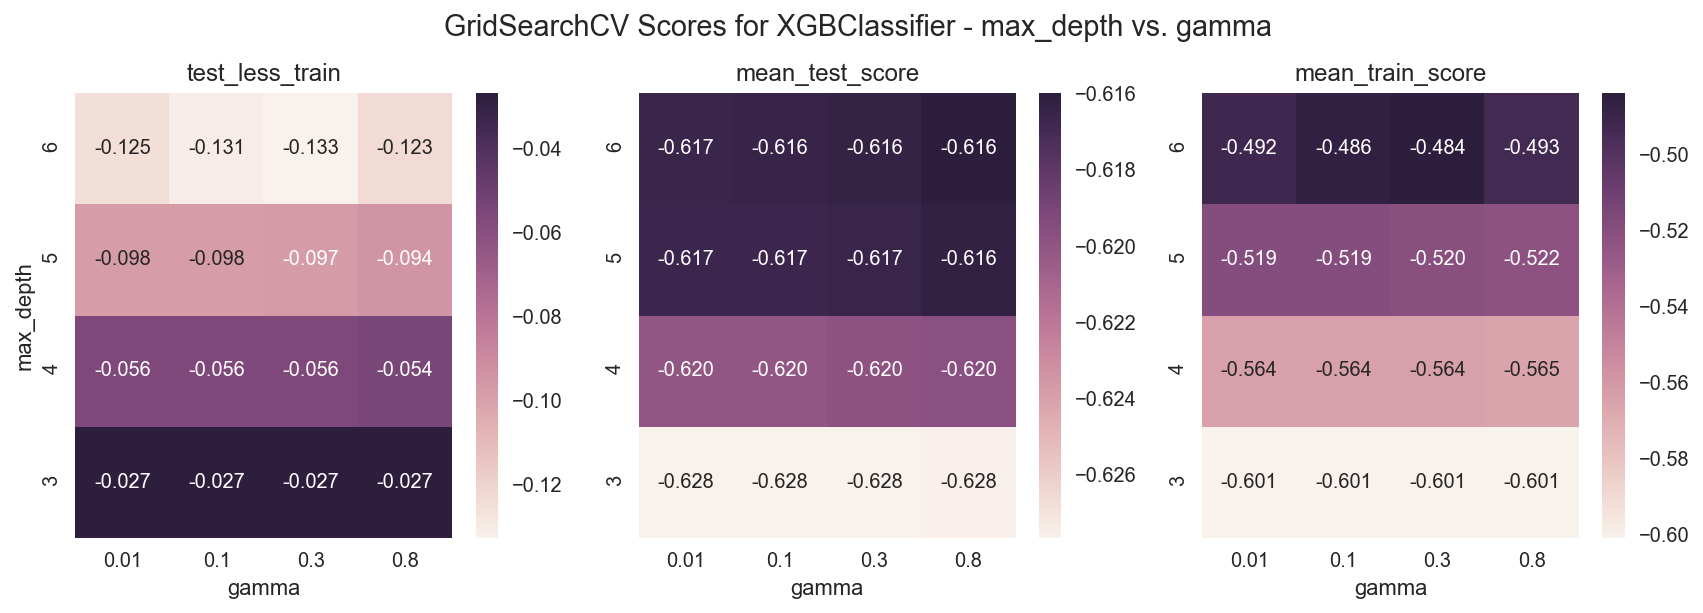

In [40]:
grid_s1 = joblib.load(GRID_S1_FP)
print('Loaded: {}'.format(GRID_S1_FP))
print()

ax = plot_grid_heatmaps(grid_s1, x='gamma', annot=True, fmt='.3f')

suptitle = 'GridSearchCV Scores for XGBClassifier - max_depth vs. gamma'
plt.suptitle(suptitle, fontsize='x-large', y=1.05)

plt.tight_layout()

__??? No effect on gamma at all ???__

In [41]:
best_params = dict(max_depth=5, gamma=0.01)

cv_results = pd.DataFrame(grid_s1.cv_results_)
display(filter_grid_results(cv_results, best_params).iloc[:, 2:4])
print('For best params: {}'.format(best_params))

,mean_test_score,mean_train_score
2,-0.6166,-0.5189


For best params: {'gamma': 0.01, 'max_depth': 5}


Gamma should be U-shaped CV (xgb.cv) according to colorful blog post: (???)

Runtime: 1min 21s



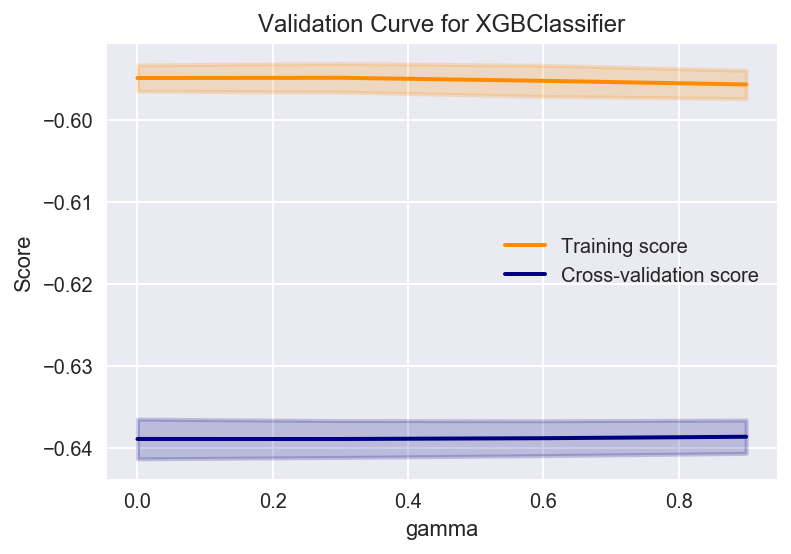

In [135]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    learning_rate=0.025,
    max_depth=6,

    objective='multi:softprob',
    missing=-999, nthread=1, seed=SEED,
)

start = time.time()
ax = plot_validation_curve(
    xgb_clf, X_train, y_train, 'gamma', np.arange(0, 1.1, .3),
    scoring=scoring, n_jobs=7
)
end = time.time()
print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))

#### Step 2: [draft gamma for now] Tune for `min_child_weight`

In [56]:
# RUN_XGB = False
# grid_s2_fp = ''.join([MODEL_DIR, 'grid_s2.pkl'])

# if RUN_XGB:
#     cv = 5
    
#     xgb_clf = XGBClassifier(
#         n_estimators=1000,
#         max_depth=10,
#         gamma=6,
#         colsample_bytree=0.5,

#         objective='multi:softprob',
#         missing=-999, nthread=1, seed=SEED,
#     )
#     params = dict(
#         max_depth=range(6, 16, 2),
#         gamma=range(0, 10, 2),
#     )
#     fit_params=dict(
#         early_stopping_rounds=50, 
#         eval_metric='mlogloss', 
#         eval_set=[(X_test, y_test)],
#         verbose=False,
#     )
#     grid_s2 = GridSearchCV(xgb_clf, params, fit_params=fit_params,
#                            scoring=scoring, cv=cv, n_jobs=-1)

#     %timeit -r1 -n1 grid_s2.fit(X_train, y_train)
    
#     joblib.dump(grid_s2, grid_s2_fp)
#     print('Pickled to: {}'.format(grid_s2_fp))
#     print()
#     print(best_grid_score(grid_s2))

Output:

```
45min 21s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each) 
Pickled to: ./Models/grid_s2.pkl

Best grid CV score: -0.6105 ± 0.0043 (mean ± std. dev.)
Train score:        -0.4805 ± 0.0021 (mean ± std. dev.)

*** For parameters: ***
gamma=4
max_depth=14
```

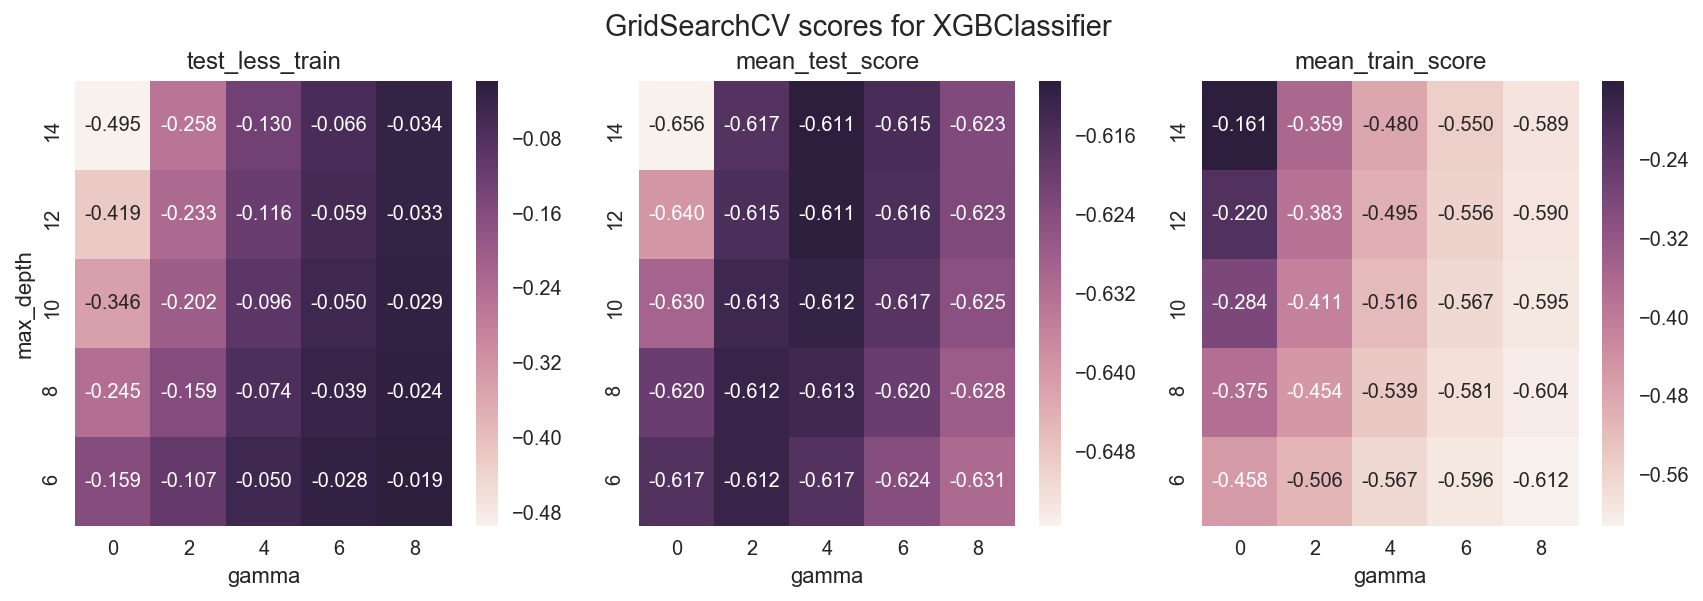

In [59]:
# grid_s2 = joblib.load(grid_s2_fp)
# plot_grid_heatmaps(grid_s2, x='gamma', annot=True, fmt='.3f')
# plt.tight_layout()

In [60]:
# best_params = dict(max_depth=6, gamma=6)

# cv_results = pd.DataFrame(grid_s2.cv_results_)
# display(filter_grid_results(cv_results, best_params).iloc[:, 2:4])
# print('For best params: {}'.format(best_params))

,mean_test_score,mean_train_score
15,-0.6242,-0.5958


For best params: {'gamma': 6, 'max_depth': 6}


#### Step 3: Tune `subsample`, `colsample_bytree` and `colsample_bylevel`

- subsample [default=1]
    - subsample ratio of the training instance.
    - Setting it to 0.5 means that XGBoost randomly collected half of the data instances to grow trees
    and this will prevent overfitting.
    - range: (0,1]  
- colsample_bytree [default=1]
    - subsample ratio of columns when constructing each tree.
    - range: (0,1]
- colsample_bylevel [default=1]
    - subsample ratio of columns for each split, in each level.
    - range: (0,1]

In [ ]:
xgb_clf.fit()

In [66]:
RUN_XGB = True

if RUN_XGB:
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        
        # worried about overfitting at the end, *and* the folding
        # process (not new though, but no effect so far hmm)
        n_estimators=300,  
        learning_rate=0.03,
        
        missing=-999, nthread=1, seed=SEED,
    )
    params = dict(
        reg_lambda=[.2, .5, .8],
        max_depth=[5, 7, 9],
#         subsample=[.4, .7, 1.],
        colsample_bytree=[.6, 1.],
#         sds colsample_bylevel=[.25, .5, .75],  # .25 like root in rand forest
    )
    
    # TODO: Look into custom feval to return best score when 
    # stopped early (instead of most recent one, default behavior).
    
    # Speeds things up primarily (and prevents some overfitting).
    # Also helps to have some way of dealing with different sizes
    # of datasets (given the folds)
#     fit_params=dict(
#         early_stopping_rounds=10, 
#         eval_metric='mlogloss', 
#         eval_set=[(X_test, y_test)],
#         verbose=True,
#     )
    grid = GridSearchCV(xgb_clf, params,# fit_params=fit_params,
                           scoring=scoring, cv=4, n_jobs=7)

    %timeit -r1 -n1 grid.fit(X_train, y_train)

    print(best_grid_score(grid))

13min 58s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6198 ± 0.0053 (mean ± std. dev.)
Train score:        -0.4124 ± 0.0031 (mean ± std. dev.)

*** For parameters: ***
colsample_bytree=0.6
max_depth=9
reg_lambda=0.8


Output:
```
11min 22s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Best grid CV score: -0.6345 ± 0.0034 (mean ± std. dev.)
Train score:        -0.6115 ± 0.0012 (mean ± std. dev.)

*** For parameters: ***
colsample_bytree=1.0
max_depth=4
subsample=0.4
```

In [56]:
len(features)

15

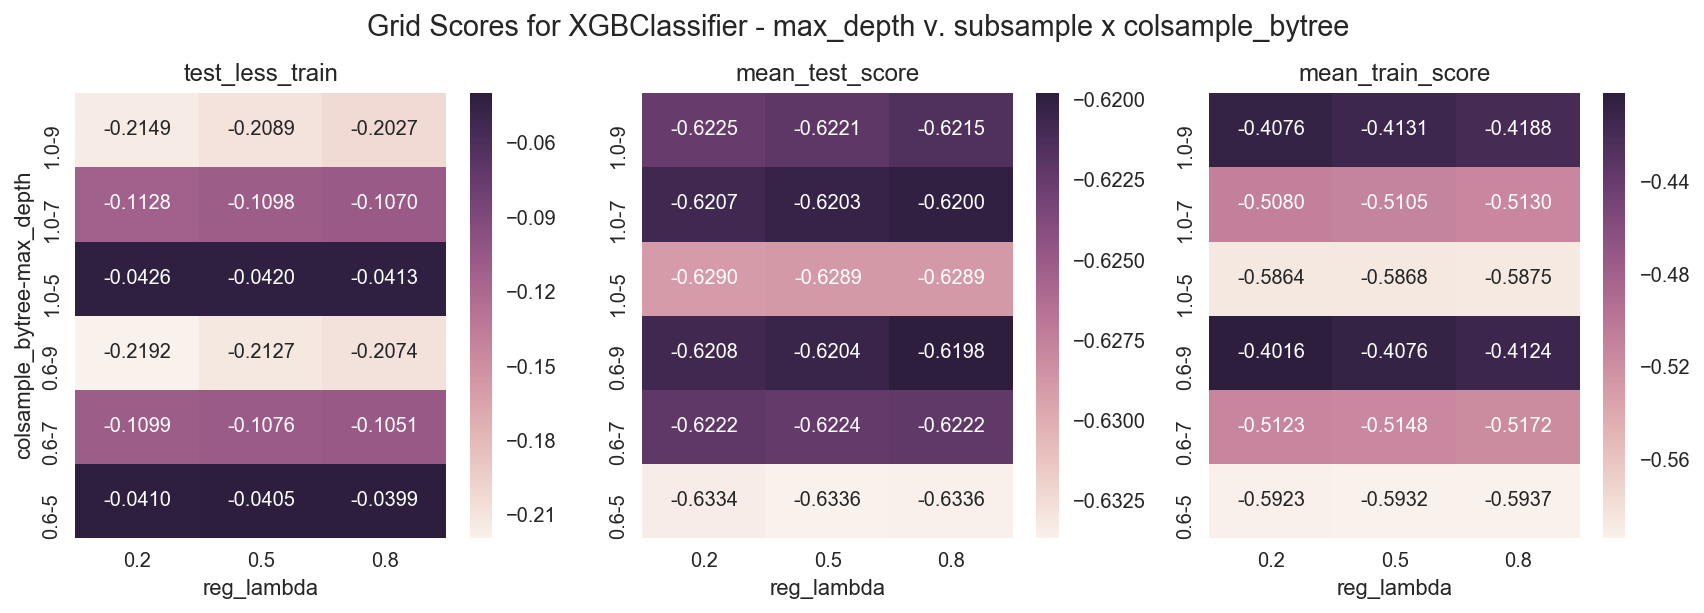

In [69]:
ax = plot_grid_heatmaps(grid, x='reg_lambda', annot=True, fmt='.4f')

suptitle = 'Grid Scores for XGBClassifier - max_depth v. subsample x colsample_bytree'
plt.suptitle(suptitle, fontsize='x-large', y=1.05)

plt.tight_layout()

In [57]:
# clf = deepcopy(grid.best_estimator_)

In [104]:
def get_xgb_imp(xgb, feat_names):
    from numpy import array
    imp_vals = xgb.booster().get_fscore()
    imp_dict = {feat_names[i]:float(imp_vals.get('f'+str(i),0.)) for i in range(len(feat_names))}
    return imp_dict

imp_dict = get_xgb_imp(grid_samp1.best_estimator_, features)
feat_by_fscore = pd.Series(imp_dict).sort_values(ascending=False).index.tolist()


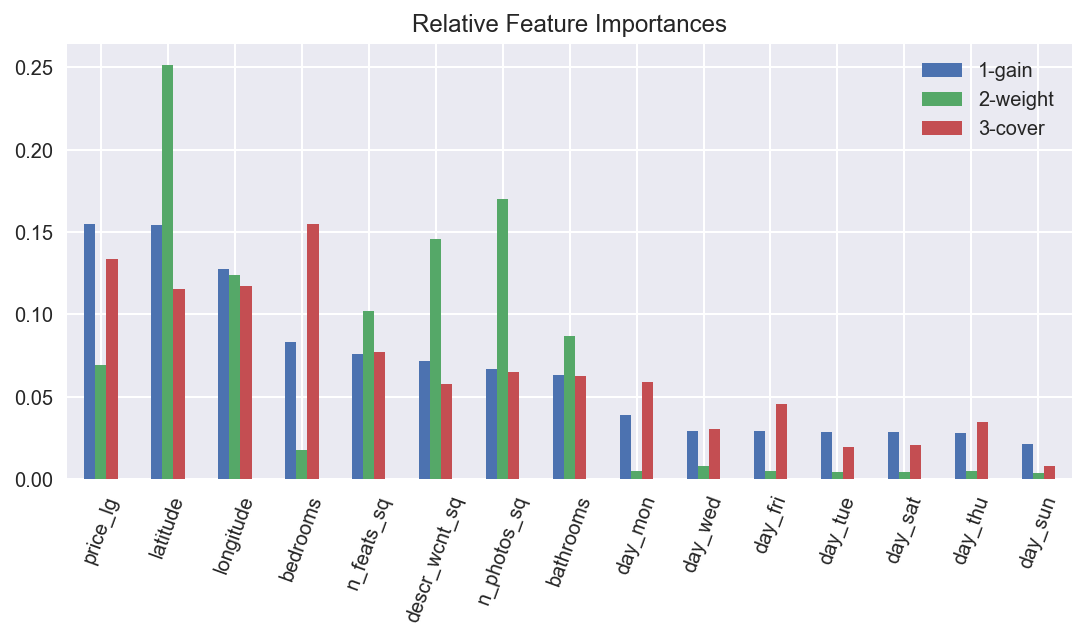

In [105]:
bst = grid_samp1.best_estimator_.booster()
score_dict = {}
for i, imp_type in enumerate(['gain', 'weight', 'cover'], 1):
    
    col_name = str(i)+'-'+imp_type  # For correct hue ordering
    score_dict[col_name] = bst.get_score(importance_type=imp_type)
feat_scores = (pd.DataFrame(score_dict)
                 .apply(lambda x: x/sum(x))
                 .sort_values('1-gain', ascending=False)
)
ax = feat_scores.plot(kind='bar', rot=70, figsize=(9, 4))
ax.set_title('Relative Feature Importances')
ax.set_xticklabels(feat_by_fscore)
plt.show()

In [ ]:
eval_hist = 

In [75]:
feat_scores.sort_index()

,1-gain,2-weight,3-cover
f0,0.1540,0.2517,0.1151
f1,0.1275,0.1238,0.1171
f10,0.0292,0.0050,0.0454
f11,0.0282,0.0038,0.0208
f12,0.0390,0.0048,0.0589
f13,0.0287,0.0040,0.0194
f14,0.0209,0.0035,0.0077
f2,0.0831,0.0176,0.1550
f3,0.0670,0.1701,0.0651
f4,0.0714,0.1458,0.0575


In [64]:
from sklearn.calibration import CalibratedClassifierCV

calb = CalibratedClassifierCV(clf, method='isotonic')



start = time.time()
scores = cross_val_score(
    estimator=calb, X=X_train, y=y_train,
    cv=5, scoring=scoring, n_jobs=-1,
)
y_pred = xgb_clf.fit(X_train, y_train).predict_proba(X_train)
end = time.time()
print('Runtime: {}min {}s'.format(*to_min_secs(end-start)))
print()
print('Mean CV score: {:>10.4f}'.format(np.mean(scores)))
print('Train score:   {:>10.4f}'.format(-log_loss(y_train, y_pred)))



Runtime: 1min 16s

Mean CV score:    -0.6305
Train score:      -0.6442


Output: Note changing results, no random_state param
```
Runtime: 1min 16s

Mean CV score:    -0.6305
Train score:      -0.6442
```

__??? No effect on gamma at all ???__

In [41]:
best_params = dict(max_depth=5, gamma=0.01)

cv_results = pd.DataFrame(grid_s1.cv_results_)
display(filter_grid_results(cv_results, best_params).iloc[:, 2:4])
print('For best params: {}'.format(best_params))

,mean_test_score,mean_train_score
2,-0.6166,-0.5189


For best params: {'gamma': 0.01, 'max_depth': 5}


#### [Failed] Step 3: Tune `subsample`, `colsample_bytree` and `colsample_bylevel`

Runtime: 0min 26s



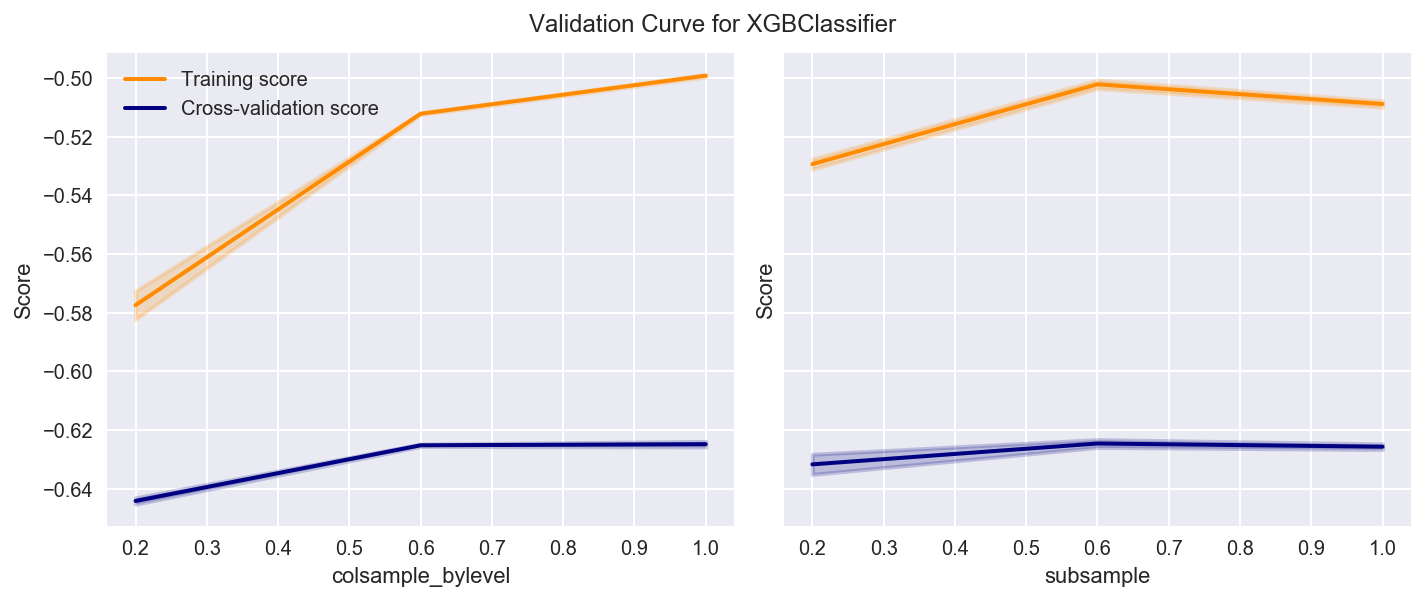

In [273]:
cv = 3

xgb_clf = XGBClassifier(
    objective='multi:softprob',
    learning_rate=0.1, n_estimators=120,
    subsample=0.8, colsample_bytree=0.8,
    missing=-999, nthread=1, seed=SEED,
    max_depth=6, min_child_weight=1,
)

start = time.time()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

param_1 = 'colsample_bylevel'
param_2 = 'subsample'

param_range = np.arange(.2, 1.2, .2)

kwargs = dict(
    estimator=xgb_clf, X=X_train, y=y_train,
    param_name=param_1, param_range=param_range,
    cv=cv, scoring=scoring, n_jobs=-1, ax=ax1, 
)
plot_validation_curve(**kwargs)

kwargs = dict(
    estimator=xgb_clf, X=X_train, y=y_train,
    param_name=param_2, param_range=param_range,
    cv=cv, scoring=scoring, n_jobs=-1, ax=ax2, 
)
plot_validation_curve(**kwargs)

fig.suptitle(ax1.get_title(), y=1.03)

ax1.set_title('')
ax2.set_title('')
ax2.legend('')

end = time.time()
print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))

plt.tight_layout()

24.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


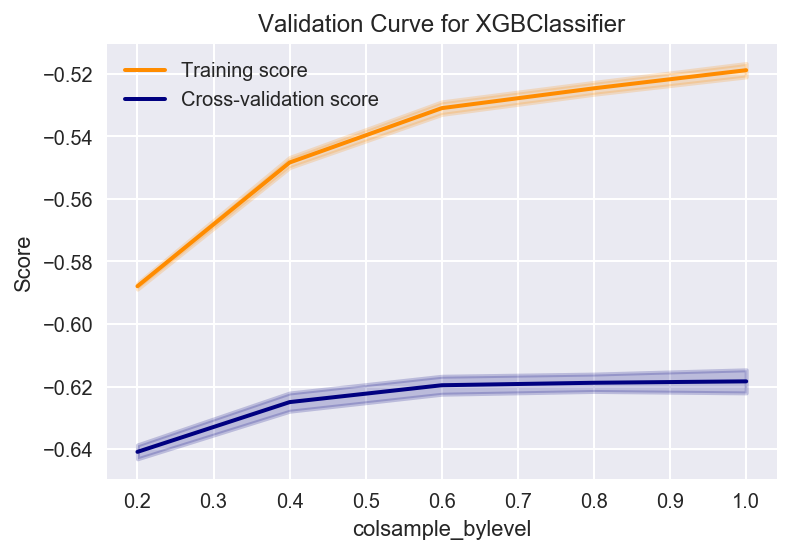

In [159]:
# so %timeit works with multiline arguments


#### Step 5: Tune `reg_alpha` and `reg_lambda`
- lambda [default=1, alias: reg_lambda]
    - L2 regularization term on weights, increase this value will make model more conservative.
- alpha [default=0, alias: reg_alpha]
    - L1 regularization term on weights, increase this value will make model more conservative.

In [ ]:
RUN_XGB = True

if RUN_XGB:
    cv =4
    
    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        
        learning_rate=0.1,
        n_estimators=500,
        
        max_depth=10,
        gamma=6,
        colsample_bytree=0.5,
        
        missing=-999,
        n_jobs=1,
        seed=SEED,
    )
    time.time()
    plot_validation_curve(
        param_name='gamma', param_range=np.arange(2, 10),
        estimator=xgb_clf, X=X_train, y=y_train,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    end = time.time()
    print('Runtime: {}min {}s\n'.format(*to_min_secs(end-start)))

In [161]:
RUN_XGB = True

if RUN_XGB:
    cv = 3

    xgb_clf = XGBClassifier(
        objective='multi:softprob',
        learning_rate=0.1, n_estimators=120,
        subsample=0.8, colsample_bytree=0.8,
        missing=-999, nthread=1, seed=SEED,
        max_depth=6, min_child_weight=1,
    )
    
#     params = dict(
#         reg_alpha=[0, 0.05, 0.1, 0.2, 0.5],
#         reg_lambda=[0, 0.05, 0.1, 0.2, 0.5],
#     )
    
    params = [
        dict(reg_alpha=[0, 0.05, 0.1, 0.2, 0.5]),
        dict(reg_lambda=[0, 0.05, 0.1, 0.2, 0.5]),
    ]
    
    grid = GridSearchCV(xgb_clf, params, n_jobs=-1,
                        scoring=scoring, cv=cv)

    %timeit -r1 -n1 grid.fit(X_train, y_train)

    print(best_grid_score(grid))

1min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6179 ± 0.0033 (mean ± std. dev.)
Train score:        -0.5221 ± 0.0020 (mean ± std. dev.)

*** For parameters: ***
reg_alpha=0.5


Output:
```
3min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Best grid CV score: -0.6178 ± 0.0034 (mean ± std. dev.)
Train score:        -0.5163 ± 0.0016 (mean ± std. dev.)

*** For parameters: ***
reg_alpha=0.5
reg_lambda=0.2
```

In [162]:
ge = GridSearchExplorer(grid)
ge.plot('reg_alpha')

TypeError: unorderable types: dict() < dict()

#### Step 6: Tune `reg_alpha` and `reg_lambda`

### Feature Selection

From [StackEx](https://datascience.stackexchange.com/questions/12318/how-do-i-interpret-the-output-of-xgboost-importance): How do i interpret the output of XGBoost importance?

_Gain_: the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model
- A higher value of this metric when compared to another feature implies it is more important for generating a prediction.
- It is the most relevant attribute to interpret the relative importance of each feature.

_Weight_: (or fscore) is the percentage representing the relative number of times a particular feature occurs in the trees of the model. 
- In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weightage for feature1 will be 2+1+3 = 6.
- The frequency for feature1 is calculated as its percentage weight over weights of all features.

_Cover_: the relative number of observations related to this feature. 
- For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. 
- This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features' cover metrics.

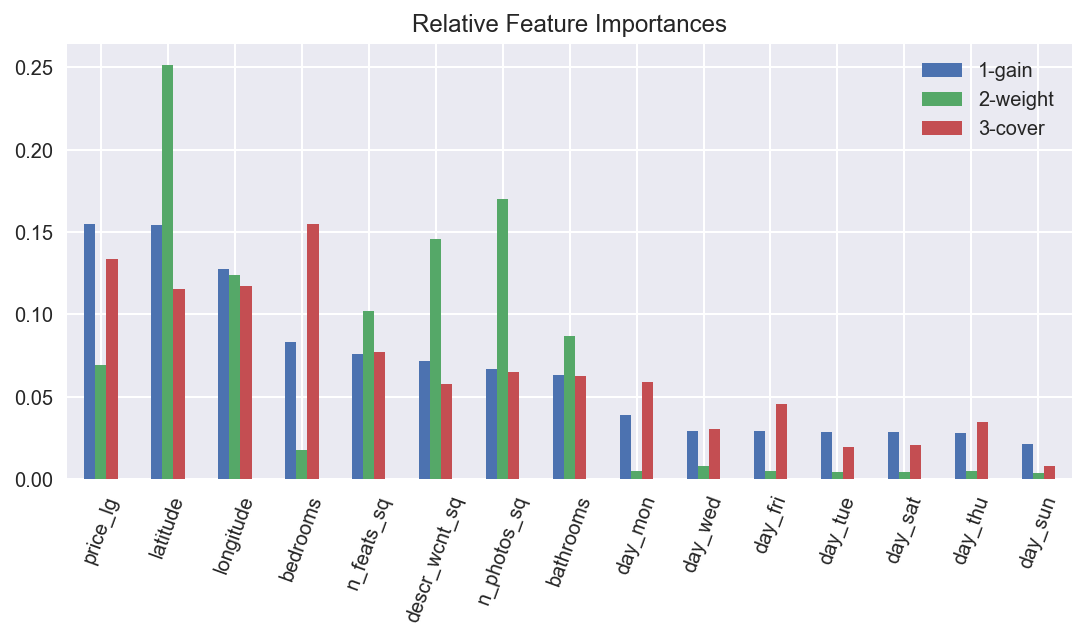

In [107]:
bst = grid_samp1.best_estimator_.booster()
score_dict = {}
for i, imp_type in enumerate(['gain', 'weight', 'cover'], 1):
    
    col_name = str(i)+'-'+imp_type  # For correct hue ordering
    score_dict[col_name] = bst.get_score(importance_type=imp_type)
    feat_scores = (pd.DataFrame(score_dict)
                     .apply(lambda x: x/sum(x))
                     .sort_values('1-gain', ascending=False)
    )
ax = feat_scores.plot(kind='bar', rot=70, figsize=(9, 4))
ax.set_title('Relative Feature Importances')
ax.set_xticklabels(feat_by_fscore)
plt.show()

In [76]:
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    learning_rate=0.1, n_estimators=120,
    subsample=0.8, colsample_bytree=0.8,
    missing=-999, nthread=1, seed=SEED,
    max_depth=6, min_child_weight=1,
)

fit_params = dict(X=X_train, y=y_train, eval_metric='mlogloss',
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  verbose=False,
)
%timeit -r1 -n1 xgb_clf.fit(**fit_params)

23.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


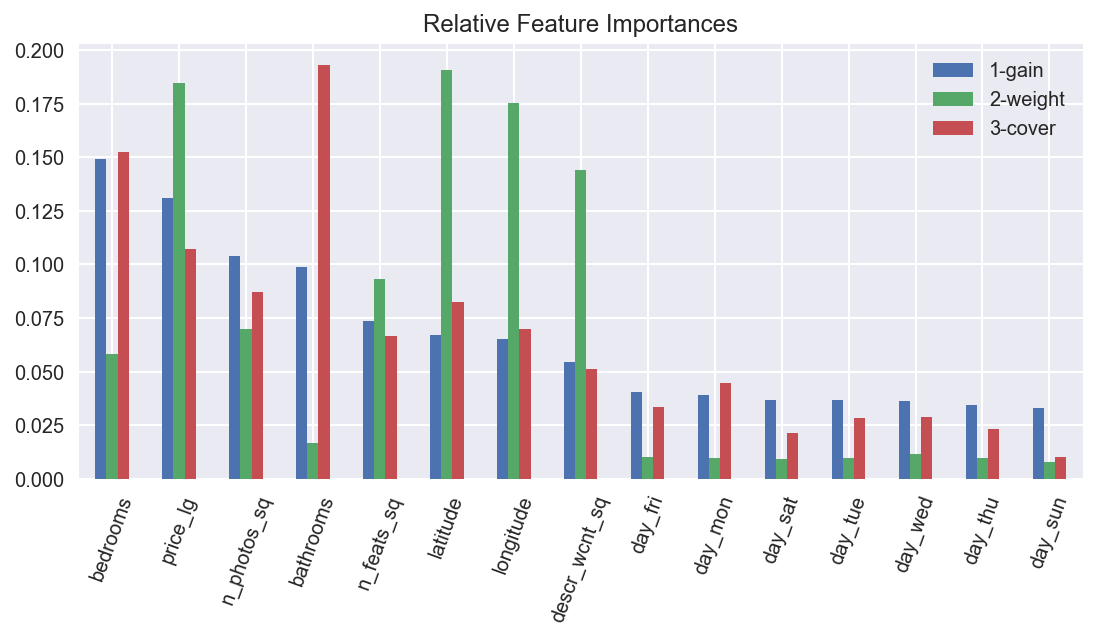

In [193]:
score_dict = {}
for i, imp_type in enumerate(['gain', 'weight', 'cover'], 1):
    
    col_name = str(i)+'-'+imp_type  # For correct hue ordering
    score_dict[col_name] = bst.get_score(importance_type=imp_type)
feat_scores = (pd.DataFrame(score_dict)
                 .apply(lambda x: x/sum(x))
                 .sort_values('1-gain', ascending=False)
)
ax = feat_scores.plot(kind='bar', rot=70, figsize=(9, 4))
ax.set_title('Relative Feature Importances')

plt.show()

In [147]:
x = (pd.DataFrame(bst.get_score(importance_type='gain'), index=['0']).T
   .sort_values(by='0', ascending=False)
   .plot(kind='bar', ax=ax1)
)

In [ ]:
plt.title('Feature Score - Gain')
(pd.DataFrame(bst.get_score(importance_type='gain'), index=['0']).T
   .sort_values(by='0', ascending=False)
   .plot(kind='bar')
)

In [127]:
df.plot()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,longitude,manager_id,photos,price,street_address
listing_id,,,,,,,,,,,,,,
7211212,1.5000,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],2,40.7145,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
7150865,1.0000,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",1,40.7947,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
6887163,1.0000,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",3,40.7388,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
6888711,1.0000,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",1,40.7539,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
6934781,1.0000,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],1,40.8241,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street
6894514,2.0000,4,38a913e46c94a7f46ddf19b756a9640c,2016-04-19 04:24:47,,West 18th Street,[],2,40.7429,-74.0028,b209e2c4384a64cc307c26759ee0c651,[https://photos.renthop.com/2/6894514_9abb8592...,7995,350 West 18th Street
6930771,1.0000,2,3ba49a93260ca5df92fde024cb4ca61f,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,"[prewar, elevator, Dogs Allowed, Cats Allowed,...",1,40.8012,-73.9660,01287194f20de51872e81f660def4784,[https://photos.renthop.com/2/6930771_7e3622b6...,3600,210 West 107th Street
6867392,2.0000,1,0372927bcb6a0949613ef5bf893bbac7,2016-04-13 06:01:42,"This huge sunny ,plenty of lights 1 bed/2 bath...",West 21st Street,"[Doorman, Elevator, Pre-War, Terrace, Laundry ...",1,40.7427,-73.9957,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6867392_b18283f6...,5645,155 West 21st Street
6898799,1.0000,1,a7efbeb58190aa267b4a9121cd0c88c0,2016-04-20 02:36:35,<p><a website_redacted,Hamilton Terrace,"[Cats Allowed, Dogs Allowed, Elevator, Laundry...",2,40.8234,-73.9457,c1a6598437b7db560cde66e5a297a53f,[https://photos.renthop.com/2/6898799_3759be4c...,1725,63 Hamilton Terrace
